# Notebook 02 — Trial vs Control: Statistical Testing & Interpretation

This notebook:
- Loads monthly aggregated data prepared in Notebook 1
- Uses selected control stores (top-1 by correlation) or lets you pick controls
- Compares each trial store vs its control during the trial period
- Runs statistical tests on **total sales** (t-test + permutation test)
- If significant, decomposes driver: **more customers** vs **more transactions per customer**
- Produces bootstrap confidence intervals and plots for quick interpretation

**How to use**
1. Set `TRIAL_START` and `TRIAL_END` to the official trial months (YYYY-MM-01 recommended)


In [25]:
import pandas as pd
import numpy as np
from pathlib import Path
from datetime import datetime
import matplotlib.pyplot as plt
from scipy import stats
import random

# Display options
pd.set_option("display.max_columns", 100)

# Reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)


In [26]:
# Paths (adjust if your layout differs)
# The developer message: the uploaded raw file path is ../data/QVI_data.csv
# Notebook 1 saved the aggregated CSV to ../data/QVI_monthly_aggregated.csv (relative to notebooks/)

file_path= Path("../data/QVI_monthly_aggregated.csv")


monthly = None
if file_path.exists():
    monthly = pd.read_csv(file_path, parse_dates=["YearMonth"])
    print("Loaded aggregated monthly from:", file_path)
else:
  display("File path is absent or incorrect")

if monthly is None:
    # fallback: try to aggregate quickly from raw uploaded CSV (path in history)
    raw_path = Path("/mnt/data/QVI_data.csv")
    if raw_path.exists():
        print("Aggregated monthly file not found — falling back to raw CSV and computing aggregation from", raw_path)
        raw = pd.read_csv(raw_path)
        raw.columns = [c.strip() for c in raw.columns]
        raw['DATE'] = pd.to_datetime(raw['DATE'], errors='coerce')
        raw['YearMonth'] = raw['DATE'].dt.to_period("M").dt.to_timestamp()
        monthly = (
            raw.groupby(["STORE_NBR","YearMonth"])
               .agg(total_sales=("TOT_SALES","sum"),
                    total_customers=("LYLTY_CARD_NBR", pd.Series.nunique),
                    total_transactions=("TXN_ID", pd.Series.nunique))
               .reset_index()
        )
        monthly["avg_tx_per_customer"] = monthly.total_transactions / monthly.total_customers
        print("Aggregated monthly from raw CSV")
    else:
        raise FileNotFoundError("Couldn't find aggregated monthly CSV or raw CSV. Put QVI_monthly_aggregated.csv into ../data/ or ensure /mnt/data/QVI_data.csv exists.")

# Ensure types
monthly['YearMonth'] = pd.to_datetime(monthly['YearMonth'])
monthly = monthly.sort_values(["STORE_NBR","YearMonth"]).reset_index(drop=True)
monthly.head()


Loaded aggregated monthly from: ..\data\QVI_monthly_aggregated.csv


,STORE_NBR,YearMonth,total_sales,total_customers,total_transactions,avg_tx_per_customer
0,1,2018-07-01,206.9,49,52,1.061
1,1,2018-08-01,176.1,42,43,1.024
2,1,2018-09-01,278.8,59,62,1.051
3,1,2018-10-01,188.1,44,45,1.023
4,1,2018-11-01,192.6,46,47,1.022


In [27]:
# Try to load selected controls produced by Notebook 1
filepath_2 = Path("../data/selected_controls_by_trial.csv")

selected_controls = None
if filepath_2.exists():
    selected_controls = pd.read_csv(filepath_2)
    print("Loaded selected_controls from:", filepath_2)

if selected_controls is None:
    # Provide a default mapping (empty) — you can edit this mapping below
    print("No selected_controls_by_trial.csv found. Edit `selected_controls_manual` below if needed.")
    selected_controls_manual = [
        {"trial_store": 77, "selected_control": None},
        {"trial_store": 86, "selected_control": None},
        {"trial_store": 88, "selected_control": None},
    ]
    selected_controls = pd.DataFrame(selected_controls_manual)

selected_controls


Loaded selected_controls from: ..\data\selected_controls_by_trial.csv


,trial_store,selected_control
0,77,167
1,86,159
2,88,159


In [28]:
# Auto-suggest: for each trial store, compute month-over-month % change in total_sales
# and list months where absolute % change exceeds a threshold (candidate start months).
def suggest_windows(trial_store, monthly_df=monthly, lookback_months=3, pct_threshold=0.20):
    s = monthly_df[monthly_df.STORE_NBR==trial_store].sort_values("YearMonth")
    s = s.set_index("YearMonth")
    s['pct_change'] = s['total_sales'].pct_change()
    candidates = s[ s['pct_change'].abs() >= pct_threshold ]
    # propose windows: for each candidate month propose a 3-month window starting that month
    proposals = []
    for m in candidates.index:
        start = m
        # propose 3-month window by default (you can adjust)
        end = (m + pd.offsets.MonthBegin(1)) + pd.offsets.MonthEnd(2)  # weird arithmetic; we'll do simpler below
        # simpler: take start and start + 2 months
        end = (pd.to_datetime(m) + pd.offsets.MonthEnd(2)).normalize()
        proposals.append({"start": pd.to_datetime(m).strftime("%Y-%m-01"), "end": end.strftime("%Y-%m-01"), "pct_change": float(s.loc[m]['pct_change'])})
    return pd.DataFrame(proposals)

# Example: show proposals for the trial stores
for t in selected_controls['trial_store'].unique():
    print(f"\nProposals for trial store {t}:")
    try:
        print(suggest_windows(t).head())
    except Exception as e:
        print("No proposals or insufficient data for store", t, "-", str(e))



Proposals for trial store 77:
        start         end  pct_change
0  2019-01-01  2019-02-01   -0.235316

Proposals for trial store 86:
Empty DataFrame
Columns: []
Index: []

Proposals for trial store 88:
Empty DataFrame
Columns: []
Index: []


In [29]:
# Option A: manually set official trial window (replace below)
# Example format: "2019-03-01" (first day of month). Adjust to official months.
TRIAL_START = "2019-03-01"
TRIAL_END   = "2019-05-01"

# Option B: accept an auto-suggestion — if you want to accept one suggestion, set these to the strings
# If TRIAL_START is None, the code below will prompt you in the notebook to pick a window from suggestions (display only).
if TRIAL_START is None:
    print("TRIAL_START is None — use the suggestion output from the previous cell to pick suitable months, or set TRIAL_START/TRIAL_END manually and re-run this cell.")
else:
    TRIAL_START = pd.to_datetime(TRIAL_START)
    TRIAL_END = pd.to_datetime(TRIAL_END)
    print("Using trial window:", TRIAL_START.strftime("%Y-%m"), "to", TRIAL_END.strftime("%Y-%m"))


Using trial window: 2019-03 to 2019-05


In [30]:
# Helper: extract trial-period monthly series for a store
def get_series_for_period(store, start, end, metric="total_sales", df=monthly):
    start = pd.to_datetime(start)
    end = pd.to_datetime(end)
    s = df[(df.STORE_NBR==store) & (df.YearMonth >= start) & (df.YearMonth <= end)].sort_values("YearMonth")
    return s.set_index("YearMonth")[metric]

# Two-sample t-test (independent) with equal_var=False (Welch)
def run_ttest(a, b):
    # Require at least 2 observations in each sample
    if len(a) < 2 or len(b) < 2:
        return {"t": np.nan, "pvalue": np.nan, "n_a": len(a), "n_b": len(b)}
    t, p = stats.ttest_ind(a, b, equal_var=False, nan_policy='omit')
    return {"t": float(t), "pvalue": float(p), "n_a": len(a), "n_b": len(b)}

# Permutation test for difference in means
def permutation_test_mean(a, b, n_perm=5000):
    a = np.array(a)
    b = np.array(b)
    if len(a)==0 or len(b)==0:
        return {"obs_diff": np.nan, "pvalue": np.nan}
    obs = np.nanmean(a) - np.nanmean(b)
    pooled = np.concatenate([a,b])
    count = 0
    for i in range(n_perm):
        np.random.shuffle(pooled)
        new_a = pooled[:len(a)]
        new_b = pooled[len(a):]
        if (np.nanmean(new_a)-np.nanmean(new_b)) >= abs(obs):
            count += 1
    pval = (count+1)/(n_perm+1)
    return {"obs_diff": float(obs), "pvalue": float(pval)}


In [31]:
# Decide trial windows for each trial store: either same window for all or individual
# By default we'll expect the user to set TRIAL_START/TRIAL_END. If not set, we only prepare the data frames.
results = []

for idx, row in selected_controls.iterrows():
    trial = int(row['trial_store'])
    control = row.get('selected_control', None)
    if pd.isna(control) or control is None:
        print(f"Skipping trial {trial} because no control selected.")
        continue
    control = int(control)
    if TRIAL_START is None:
        print(f"Trial window not set — please set TRIAL_START/TRIAL_END to run statistical tests. Skipping {trial}.")
        continue

    # extract monthly totals during trial window
    a = get_series_for_period(trial, TRIAL_START, TRIAL_END, metric="total_sales")
    b = get_series_for_period(control, TRIAL_START, TRIAL_END, metric="total_sales")

    # run tests
    ttest = run_ttest(a.values, b.values)
    perm = permutation_test_mean(a.values, b.values, n_perm=5000)

    # driver decomposition (customers vs avg tx)
    a_customers = get_series_for_period(trial, TRIAL_START, TRIAL_END, metric="total_customers")
    b_customers = get_series_for_period(control, TRIAL_START, TRIAL_END, metric="total_customers")
    a_avgtx = get_series_for_period(trial, TRIAL_START, TRIAL_END, metric="avg_tx_per_customer")
    b_avgtx = get_series_for_period(control, TRIAL_START, TRIAL_END, metric="avg_tx_per_customer")

    # compare means
    customers_diff = float(np.nanmean(a_customers) - np.nanmean(b_customers)) if len(a_customers)>0 and len(b_customers)>0 else np.nan
    avgtx_diff = float(np.nanmean(a_avgtx) - np.nanmean(b_avgtx)) if len(a_avgtx)>0 and len(b_avgtx)>0 else np.nan

    results.append({
        "trial_store": trial,
        "control_store": control,
        "n_months_trial": len(a),
        "mean_sales_trial": float(np.nanmean(a)) if len(a)>0 else np.nan,
        "mean_sales_control": float(np.nanmean(b)) if len(b)>0 else np.nan,
        "ttest_t": ttest["t"],
        "ttest_p": ttest["pvalue"],
        "perm_obs_diff": perm["obs_diff"],
        "perm_p": perm["pvalue"],
        "customers_diff": customers_diff,
        "avgtx_diff": avgtx_diff
    })

results_df = pd.DataFrame(results)
results_df


,trial_store,control_store,n_months_trial,mean_sales_trial,mean_sales_control,ttest_t,ttest_p,perm_obs_diff,perm_p,customers_diff,avgtx_diff
0,77,167,3,280.433333,205.333333,3.862290,0.024802,75.10,0.047391,3.666667,0.020333
1,86,159,3,921.433333,35.433333,16.063394,0.002681,886.00,0.051590,101.333333,0.216000
2,88,159,3,1408.283333,35.433333,26.195080,0.000886,1372.85,0.044991,123.333333,0.243333


In [32]:
# Bootstrap the mean difference in total_sales between trial and control during trial period
def bootstrap_mean_diff(a, b, n_boot=2000):
    a = np.array(a); b = np.array(b)
    diffs = []
    for _ in range(n_boot):
        sa = np.random.choice(a, size=len(a), replace=True) if len(a)>0 else np.array([])
        sb = np.random.choice(b, size=len(b), replace=True) if len(b)>0 else np.array([])
        diffs.append(np.nanmean(sa) - np.nanmean(sb))
    arr = np.array(diffs)
    return {"mean_diff": float(np.nanmean(arr)), "ci_lower": float(np.percentile(arr,2.5)), "ci_upper": float(np.percentile(arr,97.5))}

# compute and attach bootstrap CIs if TRIAL window set
if TRIAL_START is not None:
    boot_results = []
    for r in results:
        a = get_series_for_period(r['trial_store'], TRIAL_START, TRIAL_END, "total_sales")
        b = get_series_for_period(r['control_store'], TRIAL_START, TRIAL_END, "total_sales")
        if len(a)>0 and len(b)>0:
            boot = bootstrap_mean_diff(a.values, b.values, n_boot=2000)
            boot_results.append({**r, **boot})
        else:
            boot_results.append({**r, "mean_diff": np.nan, "ci_lower": np.nan, "ci_upper": np.nan})
    boot_df = pd.DataFrame(boot_results)
    display(boot_df)
else:
    print("TRIAL window not set — bootstrap skipped.")


,trial_store,control_store,n_months_trial,mean_sales_trial,mean_sales_control,ttest_t,ttest_p,perm_obs_diff,perm_p,customers_diff,avgtx_diff,mean_diff,ci_lower,ci_upper
0,77,167,3,280.433333,205.333333,3.862290,0.024802,75.10,0.047391,3.666667,0.020333,75.863433,42.533333,104.633333
1,86,159,3,921.433333,35.433333,16.063394,0.002681,886.00,0.051590,101.333333,0.216000,886.012567,812.766667,978.799167
2,88,159,3,1408.283333,35.433333,26.195080,0.000886,1372.85,0.044991,123.333333,0.243333,1373.138867,1276.783333,1441.833333


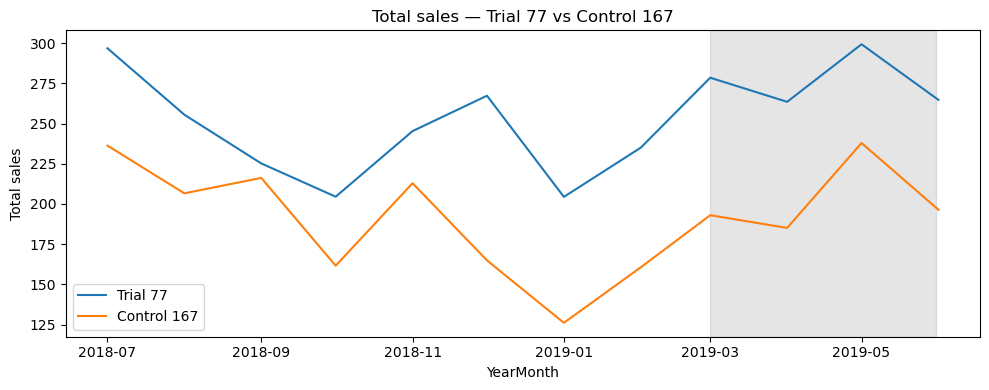

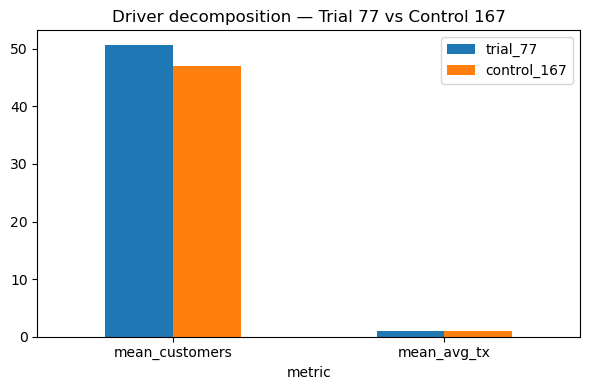

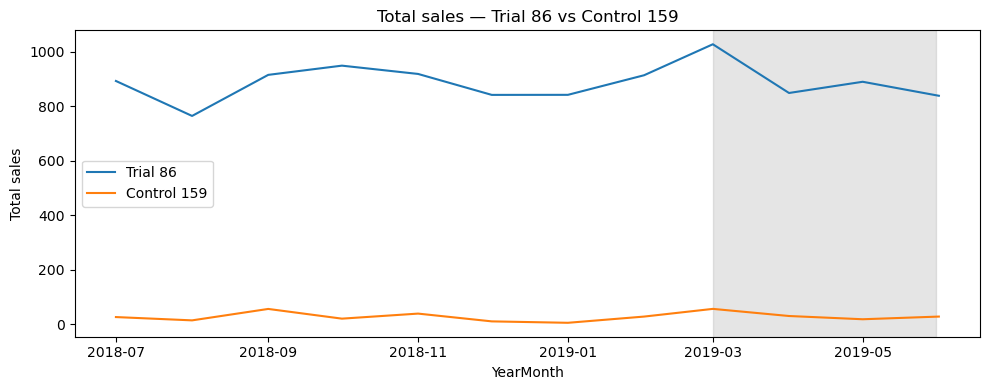

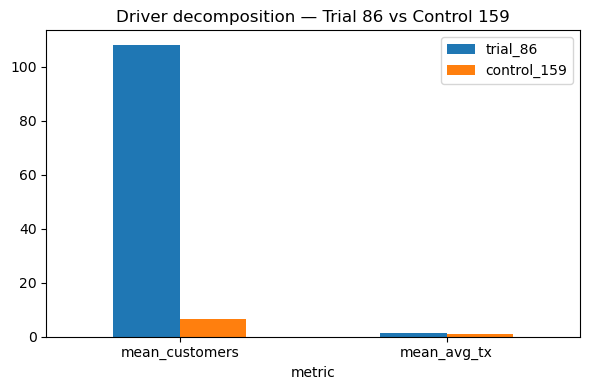

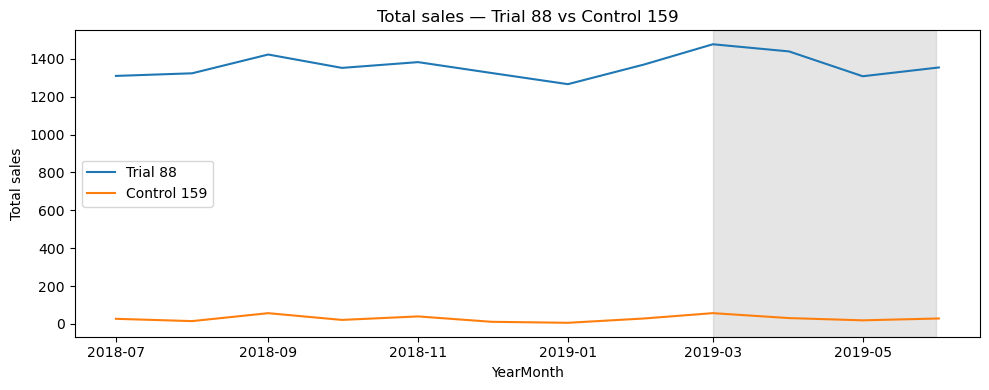

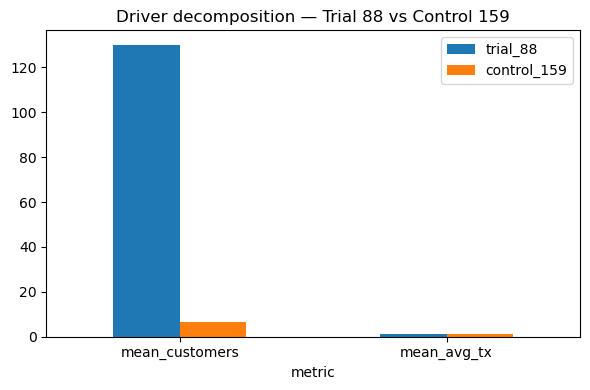

In [33]:
# For each result, plot monthly time series of total_sales for trial vs control including trial window highlight
if TRIAL_START is not None:
    ts_start = pd.to_datetime(TRIAL_START)
    ts_end = pd.to_datetime(TRIAL_END)
    for _, r in results_df.iterrows():
        t = int(r['trial_store']); c = int(r['control_store'])
        s_t = monthly[(monthly.STORE_NBR==t)].set_index("YearMonth").sort_index()
        s_c = monthly[(monthly.STORE_NBR==c)].set_index("YearMonth").sort_index()

        # align full overlap window for plotting context
        common = s_t.index.intersection(s_c.index)
        if len(common)==0:
            continue

        plt_kwargs = dict(figsize=(10,4))
        plt.figure(**plt_kwargs)
        plt.plot(s_t.index, s_t['total_sales'], label=f"Trial {t}")
        plt.plot(s_c.index, s_c['total_sales'], label=f"Control {c}")
        # highlight trial window
        plt.axvspan(ts_start, ts_end + pd.offsets.MonthEnd(0), color='grey', alpha=0.2)
        plt.title(f"Total sales — Trial {t} vs Control {c}")
        plt.xlabel("YearMonth")
        plt.ylabel("Total sales")
        plt.legend()
        plt.tight_layout()
        plt.show()

        # Plot driver bars (avg over trial window)
        a_cust = get_series_for_period(t, TRIAL_START, TRIAL_END, "total_customers")
        b_cust = get_series_for_period(c, TRIAL_START, TRIAL_END, "total_customers")
        a_avgtx = get_series_for_period(t, TRIAL_START, TRIAL_END, "avg_tx_per_customer")
        b_avgtx = get_series_for_period(c, TRIAL_START, TRIAL_END, "avg_tx_per_customer")

        df_driver = pd.DataFrame({
            "metric": ["mean_customers","mean_avg_tx"],
            f"trial_{t}": [np.nanmean(a_cust), np.nanmean(a_avgtx)],
            f"control_{c}": [np.nanmean(b_cust), np.nanmean(b_avgtx)]
        }).set_index("metric")

        df_driver.plot(kind="bar", rot=0, figsize=(6,4), title=f"Driver decomposition — Trial {t} vs Control {c}")
        plt.tight_layout()
        plt.show()
else:
    print("Set TRIAL_START / TRIAL_END to produce plots.")


In [34]:
out_dir = Path("../data")
out_dir.mkdir(parents=True, exist_ok=True)

if TRIAL_START is not None:
    results_df.to_csv(out_dir / f"trial_vs_control_results_{TRIAL_START[:7]}_{TRIAL_END[:7]}.csv", index=False)
    if 'boot_df' in globals():
        boot_df.to_csv(out_dir / f"trial_vs_control_bootstrap_{TRIAL_START[:7]}_{TRIAL_END[:7]}.csv", index=False)
    print("Saved results to", out_dir)
else:
    print("TRIAL window not set — results not saved. Set TRIAL_START/TRIAL_END and re-run the notebook to save outputs.")


TypeError: 'Timestamp' object is not subscriptable

# Interpretation template (fill after running tests)

For each trial store:

- **Trial store X vs control Y**  
  - Mean monthly total sales (trial): ____  
  - Mean monthly total sales (control): ____  
  - t-test (Welch) t = ____, p = ____  (interpretation: if p < 0.05 → statistically significant difference at α=0.05)  
  - Permutation test p = ____ (supports t-test if < 0.05)
  - Bootstrap mean difference 95% CI: [__, __] (if CI does not include 0 → supports non-zero difference)
  - **Driver decomposition**: difference in mean customers = __ ; difference in avg tx per customer = __  
    - If customers_diff >> avgtx_diff → increase driven by more purchasing customers.  
    - If avgtx_diff >> customers_diff → increase driven by more purchases per customer.
  - **Practical significance**: comment on effect size (e.g., monthly uplift of $X which represents Y% of baseline)


# Export to PDF

When you're happy with the notebook and markdown write-up, export to PDF for submission:

Option 1 — from Jupyter UI:
`File → Print Preview → Print` (save as PDF) or `File → Download as → PDF via LaTeX` (if configured).

Option 2 — command line (run from the repository root):
